#  Прогнозирование сроков доставки

Для интернет-магазина «SoftMatras» необходимо разработать модель прогнозирования сроков доставки заказа. Интернет-магазин является дилером, а доставка осуществляется силами производителя. Данное решение позволит:

* Не терять каналы продаж в виде маркетплейсов, избегая блокировок из-за сроков доставки.  
* Выставлять конкурентно способные сроки доставки, тем самымы привлекая больше клиентов.
* Уменьшать время обработки заказов.
* При заказе через интернет-магазин выводит клиентам примерные сроки доставки.

В качестве метрики была выбрана RMSE.

## 1. Предобработка

In [257]:
# импорт библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import glob 
import datetime
import pickle

from sqlalchemy import create_engine, text
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

In [258]:
# константы
# определяем стандартные и не стандартный размер
# в данном списке находятся стандартные размеры дестких и взрослых матрасов
RANDOM_STATE = 42

STANDART_SIZE = ['80 x 190',
                 '80 x 200',
                 '90 x 190',
                 '90 x 200',
                 '120 x 190',
                 '120 x 200',
                 '140 x 190',
                 '140 x 200',
                 '160 x 190',
                 '160 x 200',
                 '180 x 190',
                 '180 x 200',
                 '200 x 190',
                 '200 x 200']

STANDART_BABY_SIZE = ['60 x 120',
                      '65 x 120',
                      '65 x 125',
                      '70 x 140',
                      '60 x 145',
                      '60 x 150',
                      '70 x 160',
                      '75 x 175',
                      '80 x 160',
                      '80 x 180',
                      '80 x 190',
                      '80 x 195',
                      '80 x 200',
                      '90 x 180',
                      '90 x 190',
                      '90 x 195',
                      '90 x 200']

In [259]:
# Фиксируем рандом
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

На старте работы необходимо было выяснить, что влияет на сроки доставки. В результате, выяснилось следующие:

* Размеры матрасов: стандартные и не стандартные:<br>
 -Стандартные матрасы изготовляются быстрее<br>
 -Не стандартные матрасы изготовляются медленнее, требуется заявление от клиента<br>
* От серии матрасов.
* Регион. 
* Наличие матрасов на складе, как правило в наличии бывают только матрасы стандартного размера.
* Расстояние от склада до клиента
* Время в пути
* Гео позиция
* Выходные дни
* Время обработки заказа


В данном интернет магазине данные были заполненны с ошибками, нужно было их привести в порядок. Так же более половины признаков отсутсвовало, в ходе работы над проектом было решено сгенерировать необходимые признаки.

Для генерации и очистки нужных признаков использовались сторонние сервисы:
* Dadata - стандартизация адресов, получение региона по адресу, а также гео координат.
* project-osrm.org - сервис для рассчета расстояния от склада до клиента, а так же времени в пути

В качестве языка использовался PHP, более детально можно посмотреть в **index_step_1.ipynb**

In [260]:
# подключимся к базе
db_config = {
    'user': '****',
    'pwd': '****', 
    'host': '****',
    'db': '****' 
} 

connection_string = 'mysql+pymysql://{}:{}@{}:3306/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['db'],
)

engine = create_engine(connection_string)

Напишем запрос для получения всех выполненных заказов производителя аскона

In [261]:
# старый запрос
# запрос был переписан т.к необходимо было изменить целевую переменную
query = '''SELECT DISTINCT so.id,
                        so.create_datetime,
                        sol2.datetime otpravit_v_proizvodstvo,
                        timestampdiff(DAY, so.create_datetime, sol2.datetime) diff_create_send_time,
                        timestampdiff(DAY, so.create_datetime, so.update_datetime) order_created_finished_day,
                        sop2.value distance,
                        sop3.value duration,
                        IF (timestampdiff(DAY, so.create_datetime, so.update_datetime) < 7, 1, 0) in_stock,
                        soi.quantity,
                        sop.value region,
                        so.total, 
                        soi.name,
                        sol.text,
                        t1.collection,
                        sop5.value client_lat,
                        sop6.value client_lng,
                        so.total 
                FROM shop_product_features spf 
                JOIN shop_order_items soi ON spf.product_id = soi.product_id 
                JOIN shop_order so ON soi.order_id = so.id 
                JOIN shop_order_params sop ON sop.order_id = so.id
                JOIN shop_order_params sop2 ON sop2.order_id = so.id
                    AND sop2.name = \'distance\'
                JOIN shop_order_params sop3 ON sop3.order_id = so.id
                    AND sop3.name = \'duration\'
                LEFT JOIN shop_order_params sop4 ON sop4.order_id = so.id
                    AND sop4.name = \'shipping_address.osobennosti\' 
                    AND (sop4.value LIKE \'%%есть%%\' OR sop4.value LIKE \'%%В наличии%%\') 
                JOIN shop_order_params sop5 ON sop5.order_id = so.id
                    AND sop5.name = \'shipping_address.lat\'  
                JOIN shop_order_params sop6 ON sop6.order_id = so.id
                    AND sop6.name = \'shipping_address.lng\'         
                LEFT JOIN shop_order_log sol ON sol.order_id = so.id
                    AND sol.text = \'Менеджер: Брандт Евгения(Мен.)\'
                LEFT JOIN shop_order_log sol2 ON sol2.order_id = so.id
                            AND sol2.action_id = \'otpravit-v-proizvodstvo\'   
                /*LEFT JOIN shop_order_log sol3 ON sol3.order_id = so.id
                            AND sol3.action_id = \'otpravlen-v-pr-vo-schet-oplachen\'  
                LEFT JOIN shop_order_log sol4 ON sol4.order_id = so.id
                            AND sol4.action_id = \'otpravlen-v-pr-vo\' 
                LEFT JOIN shop_order_log sol5 ON sol5.order_id = so.id
                            AND sol5.action_id = \'otpravlen-v-pr-vo-ozhidaem-schet\'*/                       
                LEFT JOIN (SELECT spf.product_id,
                                sfvv.value collection 
                                FROM shop_product_features spf 
                            LEFT JOIN shop_feature_values_varchar sfvv ON sfvv.feature_id = spf.feature_id 
                                AND sfvv.id = spf.feature_value_id 
                            WHERE spf.product_id IN (SELECT product_id  
                                                    FROM shop_product_features spf
                                                    WHERE spf.feature_id = 78
                                                        AND spf.feature_value_id = 15458)
                                AND spf.feature_id = 158) t1 ON t1.product_id = soi.product_id 
                WHERE spf.feature_id = 78
                    AND spf.feature_value_id = 15458
                    AND so.state_id = 'completed'
                    AND sop.name = 'shipping_address.region' '''

In [262]:
data = pd.DataFrame(engine.connect().execute(text(query)))

In [263]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1794 entries, 0 to 1793
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id                          1794 non-null   int64         
 1   create_datetime             1794 non-null   datetime64[ns]
 2   otpravit_v_proizvodstvo     1428 non-null   datetime64[ns]
 3   diff_create_send_time       1428 non-null   float64       
 4   order_created_finished_day  1794 non-null   int64         
 5   distance                    1794 non-null   object        
 6   duration                    1794 non-null   object        
 7   in_stock                    1794 non-null   int64         
 8   quantity                    1794 non-null   object        
 9   region                      1794 non-null   object        
 10  total                       1794 non-null   object        
 11  name                        1794 non-null   object      

Признаки:
* id - номер заказа
* create_datetime - время создания заказа
* otpravit_v_proizvodstvo  - дата отправки в производство (в следующий статус)
* diff_create_send_time - время обрабатки (разница между otpravit_v_proizvodstvo и create_datetime)
* distance - дистанция до адреса
* duration - время в пути
* in_stock - в наличии
* quantity - количество товара в заказе
* region - номер региона
* total  - цена
* name - название товара. В названии присутствует размер, что позваляет определить является ли он стандартным или не стандартным
* text - коммент в заказе о наличии
* collection - коллекция матраса
* client_lat - координаты клиента
* client_lng  - координаты клиента
* total - итоговая стоимости заказа

Целевой признак:
* order_created_finished_day - разница между датой создания и датой завершения заказа (в днях)

В целевую переменную входит время обработки заказа менеджером, т.е к целевой переменной может добавиться 1-3 дня обработки заказа, а если его "забыли" в статусе, то можно посчитать выбросом.

В ходе дополнительных консультаций, выяснилось что на почту приходит ежедневный отчет о состоянии заказов. Необходимо получить весь список отчетов за год и связать их с текущими заказами.

In [264]:
# новый запрос
#
query = '''SELECT DISTINCT so.id,
        so.create_datetime,
  wc.name contact_name,
        soi.name product_name,
        sol2.datetime send_to_product_payd,
        sol3.datetime send_to_product_will_pay,
        IF(t1.collection IS NULL, 'unknown', t1.collection) collection,
        sop5.value region_id,
        sop.value distance,
        sop.value duration,
        sop3.value client_lat,
        sop4.value client_lng
FROM shop_order so
LEFT JOIN shop_order_items soi ON so.id = soi.order_id
JOIN shop_product_features spf ON spf.product_id = soi.product_id
LEFT JOIN shop_order_log sol ON sol.order_id = so.id
 AND sol.text = 'Менеджер: Брандт Евгения(Мен.)'
LEFT JOIN wa_contact wc ON wc.id = so.contact_id
LEFT JOIN (SELECT spf.product_id,
                                sfvv.value collection 
                                FROM shop_product_features spf 
                            LEFT JOIN shop_feature_values_varchar sfvv ON sfvv.feature_id = spf.feature_id 
                                AND sfvv.id = spf.feature_value_id 
                            WHERE spf.product_id IN (SELECT product_id  
                                                    FROM shop_product_features spf
                                                    WHERE spf.feature_id = 78
                                                        AND spf.feature_value_id = 15458)
                                AND spf.feature_id = 158) t1 ON t1.product_id = soi.product_id 
LEFT JOIN shop_order_params sop ON sop.order_id = so.id
 AND sop.name = 'distance'
LEFT JOIN shop_order_params sop2 ON sop2.order_id = so.id
    AND sop2.name = 'duration'
LEFT JOIN shop_order_params sop3 ON sop3.order_id = so.id
 AND sop3.name = 'shipping_address.lat'  
LEFT JOIN shop_order_params sop4 ON sop4.order_id = so.id
 AND sop4.name = 'shipping_address.lng'
LEFT JOIN shop_order_params sop5 ON sop5.order_id = so.id 
 AND sop5.name = 'shipping_address.region'
LEFT JOIN shop_order_log sol2 ON sol2.order_id = so.id
 AND sol2.action_id = 'oplachen-i-otpravlen-v-proizvods'
LEFT JOIN shop_order_log sol3 ON sol3.order_id = so.id
 AND sol3.action_id = 'otpravlen-v-pr-vo'
WHERE spf.feature_id = 78
 AND spf.feature_value_id = 15458
    AND so.state_id = 'completed'
    AND sol.text IS NULL
'''

In [265]:
data = pd.DataFrame(engine.connect().execute(text(query)))

In [266]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1824 entries, 0 to 1823
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id                        1824 non-null   int64         
 1   create_datetime           1824 non-null   datetime64[ns]
 2   contact_name              1824 non-null   object        
 3   product_name              1824 non-null   object        
 4   send_to_product_payd      1402 non-null   datetime64[ns]
 5   send_to_product_will_pay  276 non-null    datetime64[ns]
 6   collection                1824 non-null   object        
 7   region_id                 1824 non-null   object        
 8   distance                  1767 non-null   object        
 9   duration                  1767 non-null   object        
 10  client_lat                1810 non-null   object        
 11  client_lng                1810 non-null   object        
dtypes: datetime64[ns](3)

Признаки:
* id - номер заказа
* create_datetime - время создания заказа
* contact_name - имя пользователя
* product_name - название товара, включая размер. Позволит определить стандарт/не стандарт.
* send_to_product_payd - отправлен в производтво и оплачен
* send_to_product_will_pay - отправлен в производство, будет оплачен при получении
* collection - название коллекции 
* region_id - номер региона
* distance - расстояние от склада до клиента в метрах
* duration - время, за которое будет преодолена дистанция до клиента в секундах
* client_lat, client_lng - координаты

Целевой признак:
* days_order_fineshed - дата доставки, будет получен из файлов


In [267]:
# Удалим пустые значения
# Они означают что статус были добавлены позже

data.loc[~data['send_to_product_will_pay'].isnull(), 'send_to_product'] = data.loc[~data['send_to_product_will_pay'].isnull()]['send_to_product_will_pay']
data.loc[~data['send_to_product_payd'].isnull(), 'send_to_product'] = data.loc[~data['send_to_product_payd'].isnull()]['send_to_product_payd']
data = data[~data['send_to_product'].isnull()].drop(['send_to_product_payd', 'send_to_product_will_pay'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1656 entries, 0 to 1823
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               1656 non-null   int64         
 1   create_datetime  1656 non-null   datetime64[ns]
 2   contact_name     1656 non-null   object        
 3   product_name     1656 non-null   object        
 4   collection       1656 non-null   object        
 5   region_id        1656 non-null   object        
 6   distance         1615 non-null   object        
 7   duration         1615 non-null   object        
 8   client_lat       1644 non-null   object        
 9   client_lng       1644 non-null   object        
 10  send_to_product  1656 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(8)
memory usage: 155.2+ KB


Соеденим файлы и результат выполнения запроса.

Код скачивания файлов с почты доступен в файле **get_emails.py**

In [268]:
# считываем xlsx файлы
list_of_data = [pd.read_excel(filename) for filename in glob.glob('prace_auto_dow/*.xlsx')]
df = pd.concat(list_of_data, axis=0)

In [269]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105442 entries, 0 to 673
Data columns (total 32 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   PNT                                     105442 non-null  object        
 1   ДО                                      105442 non-null  object        
 2   Статус заказа                           105442 non-null  object        
 3   Статус строки заказа                    105437 non-null  object        
 4   Дата оформления заказа                  105442 non-null  datetime64[ns]
 5   Плановая дата завершения заказа         105353 non-null  datetime64[ns]
 6   Дата последнего изменения заказа        105442 non-null  datetime64[ns]
 7   МЦ                                      105442 non-null  object        
 8   Количество единиц МЦ из позиций заказа  105442 non-null  int64         
 9   Сумма                                   

In [270]:
# информация, которую нежелательно показывать
# по этому вывод убран
#df.head(3)

In [271]:
# В именах клиентов производитель ставит технические пометки
# которые нам не нужны
# так же получим только выполненные заказы
df['Контрагент'] = df['Контрагент'].apply(lambda x:str(x).replace('+', ''))

df = df[df['Статус заказа'] == 'Отгрузка завершена']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73855 entries, 0 to 617
Data columns (total 32 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   PNT                                     73855 non-null  object        
 1   ДО                                      73855 non-null  object        
 2   Статус заказа                           73855 non-null  object        
 3   Статус строки заказа                    73855 non-null  object        
 4   Дата оформления заказа                  73855 non-null  datetime64[ns]
 5   Плановая дата завершения заказа         73855 non-null  datetime64[ns]
 6   Дата последнего изменения заказа        73855 non-null  datetime64[ns]
 7   МЦ                                      73855 non-null  object        
 8   Количество единиц МЦ из позиций заказа  73855 non-null  int64         
 9   Сумма                                   73855 non-nu

In [272]:
# Заказы могут оформлятся задним числом
# или на день-два позже
# напишем функцию для связывания заказов
def link(x):

    date = datetime.datetime.strptime(str(x['send_to_product']).split(' ')[0], "%Y-%m-%d").date() 
    

    list_contact = str(x['contact_name']).replace('*', '')
    list_contact = list_contact.split(' ')

    if len(list_contact) == 2:
        find_name = df['Контрагент'].str.contains('{}'.format(list_contact[0])) &  df['Контрагент'].str.contains('{}'.format(list_contact[1]))
    else:
        find_name = df['Контрагент'].str.contains('{}'.format(str(x['contact_name'])))    
    
    filter = (find_name) & (df['Дата оформления заказа'] == str(date))
    
    if len(df[filter]['ДО'].values) > 0:
        #Дата оформления заказа
        return pd.Series([df[filter]['ДО'].values[0], df[filter]['Дата оформления заказа'].values[0], df[filter]['Дата в произ'].values[0], df[filter]['Дата в Развоз Строка'].values[0]], index=['askona_id', 'askona_date_order', 'askona_send_to_product', 'askona_delivery'])
    
    str_date = str(date - pd.DateOffset(1)).split(' ')[0]
    filter = (find_name) & (df['Дата оформления заказа'] == str_date)
    
    if len(df[filter]['ДО'].values) > 0:
        return pd.Series([df[filter]['ДО'].values[0], df[filter]['Дата оформления заказа'].values[0], df[filter]['Дата в произ'].values[0], df[filter]['Дата в Развоз Строка'].values[0]], index=['askona_id', 'askona_date_order', 'askona_send_to_product', 'askona_delivery'])
    
    str_date = str(date - pd.DateOffset(2)).split(' ')[0]
    filter = (find_name) & (df['Дата оформления заказа'] == str_date)
    
    if len(df[filter]['ДО'].values) > 0:
        return pd.Series([df[filter]['ДО'].values[0], df[filter]['Дата оформления заказа'].values[0], df[filter]['Дата в произ'].values[0], df[filter]['Дата в Развоз Строка'].values[0]], index=['askona_id', 'askona_date_order', 'askona_send_to_product', 'askona_delivery'])
    
    str_date = str(date - pd.DateOffset(3)).split(' ')[0]
    filter = (find_name) & (df['Дата оформления заказа'] == str_date)
    
    if len(df[filter]['ДО'].values) > 0:
        return pd.Series([df[filter]['ДО'].values[0], df[filter]['Дата оформления заказа'].values[0], df[filter]['Дата в произ'].values[0], df[filter]['Дата в Развоз Строка'].values[0]], index=['askona_id', 'askona_date_order', 'askona_send_to_product', 'askona_delivery'])
    
    str_date = str(date + pd.DateOffset(1)).split(' ')[0]
    filter = (find_name) & (df['Дата оформления заказа'] == str_date)
    
    if len(df[filter]['ДО'].values) > 0:
        return pd.Series([df[filter]['ДО'].values[0], df[filter]['Дата оформления заказа'].values[0], df[filter]['Дата в произ'].values[0], df[filter]['Дата в Развоз Строка'].values[0]], index=['askona_id', 'askona_date_order', 'askona_send_to_product', 'askona_delivery'])
    
    str_date = str(date + pd.DateOffset(2)).split(' ')[0]
    filter = (find_name) & (df['Дата оформления заказа'] == str_date)
    
    if len(df[filter]['ДО'].values) > 0:
        return pd.Series([df[filter]['ДО'].values[0], df[filter]['Дата оформления заказа'].values[0], df[filter]['Дата в произ'].values[0], df[filter]['Дата в Развоз Строка'].values[0]], index=['askona_id', 'askona_date_order', 'askona_send_to_product', 'askona_delivery'])

In [273]:
# применим
data[['askona_id', 'askona_date_order', 'askona_send_to_product', 'askona_delivery']] = data.apply(lambda x: link(x), axis=1)

C:\Users\User\AppData\Local\Temp\ipykernel_15172\3039434682.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  find_name = df['Контрагент'].str.contains('{}'.format(str(x['contact_name'])))


In [274]:
# удалим то, что не удалось связать
data = data[~data['askona_id'].isnull()]

# удалим заказы с нулевой дистанцией
data = data[~data['distance'].isnull()]

In [275]:
# получим целевую переменную
data['days_order_fineshed'] = data.apply(lambda x: (x['askona_delivery'] - x['send_to_product']).days, axis=1)

In [276]:
# количество дней в производстве 
# поможет для расчета доставки 
# если пусто, значит матрас был на складе, т.е ставим 0

data['days_in_product'] = data[~data['askona_send_to_product'].isna()].apply(
    lambda x: (x['askona_send_to_product'] - x['askona_date_order']).days, axis=1)

data.loc[data['days_in_product'].isna(), 'days_in_product'] = 0

In [277]:
# удалим заказы у которых дата производвства выше чем, дата завершения
data = data.query('days_order_fineshed > days_in_product')

In [278]:
# функция определения стандартного/нестандартного размера 
def size(x, standart_size, standart_baby_size, set_size=0):
    #for size in standart_size:
    size = 0
    if x['collection'] == 'Baby':
        for s in standart_baby_size:
            if s in x['product_name']:
                if set_size == 1:
                    size = s
                else:
                    size = 1
                break;
    else:
        for s in standart_size:
            if s in x['product_name']:
                if set_size == 1:
                    size = s
                else:
                    size = 1
                break;
    return size

In [279]:
# получим стандарт / не стандарт
data['standart_size'] = data.apply(lambda x: size(x, STANDART_SIZE, STANDART_BABY_SIZE), axis=1)

In [280]:
# заполним наличие
data.loc[data['askona_send_to_product'].isnull(), 'in_stock'] = 1
data.loc[~data['askona_send_to_product'].isnull(), 'in_stock'] = 0

In [281]:
# получим месяц, день недели и день оформления заказа

data['month'] = data['askona_date_order'].apply(lambda x: x.month)
data['day'] = data['askona_date_order'].apply(lambda x: x.day)
data['dayofweek'] = data['askona_date_order'].apply(lambda x: x.dayofweek)

In [282]:
# количество дней в доставке
data['days_delivery'] = data.apply(lambda x: (x['askona_delivery'] - x['askona_send_to_product']).days, axis=1)

In [283]:
# функция генерации сезонности
# т.к скорость доставки зависит от времени года
def seazon(x):
    month = x['month']
    if month in [1, 2, 3]:
        return 1
    elif month in [4, 5, 6]:
        return 2
    elif month in [7, 8, 9]:
        return 3
    return 4

In [284]:
# узнаем сезон
data['seazon'] = data.apply(lambda x: seazon(x), axis=1)
data_grouped = data.groupby(['region_id', 'seazon'])[['days_in_product', 'days_delivery']].mean().reset_index()

# сохраним файл для использования в готовой модельке
data_grouped.to_csv('grouped_data.csv')

In [285]:
# расчет среднего времени в производстве
# расчет среднего времени доставки
# по сезонам
data['avg_time_in_product'] = data.apply(
    lambda x: data_grouped[(data_grouped['seazon'] == x['seazon']) & (data_grouped['region_id'] == x['region_id'])]['days_in_product'].values[0], axis=1)

data['avg_time_in_delivery'] = data.apply(
    lambda x: data_grouped[(data_grouped['seazon'] == x['seazon']) & (data_grouped['region_id'] == x['region_id'])]['days_delivery'].values[0], axis=1)

In [286]:
# разница между созданием заказа
# передачу в аскону
data['diff_time_sm_askona'] = data.apply(lambda x:((x['askona_date_order'] - x['create_datetime']).days), axis=1)
data['diff_time_sm_askona'] = data.apply(lambda x: 0 if x['diff_time_sm_askona'] < 0 else x['diff_time_sm_askona'], axis=1)

In [287]:
data_grouped = data.groupby(['region_id', 'seazon'])[['diff_time_sm_askona']].mean().reset_index()

data['avg_diff_time_sm_askona'] = data.apply(
    lambda x: data_grouped[(data_grouped['seazon'] == x['seazon']) & (data_grouped['region_id'] == x['region_id'])]['diff_time_sm_askona'].values[0], axis=1)

In [288]:
# Все что выше 55 дней считаем выбросами
# т.к макс срок ожидания до месяца, в новый год до 1.5 месяца
# все что менее суток же выбросы, т.к есть процесс соглосования заказа
# удалям записи без геопозиций
 
data = data.query('days_order_fineshed > 1')
data = data.query('days_order_fineshed < 55')
data = data[data['client_lat'] != '']

In [289]:
# пустые значения доставки
# заполним средним и минимальным в двое суток
data.loc[data['days_delivery'].isnull(), 'days_delivery'] = data['days_delivery'].mean()
data.loc[data['avg_time_in_delivery'].isnull(), 'avg_time_in_delivery'] = 2

In [290]:
# итоговый датасет 
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1146 entries, 1 to 1823
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       1146 non-null   int64         
 1   create_datetime          1146 non-null   datetime64[ns]
 2   contact_name             1146 non-null   object        
 3   product_name             1146 non-null   object        
 4   collection               1146 non-null   object        
 5   region_id                1146 non-null   object        
 6   distance                 1146 non-null   object        
 7   duration                 1146 non-null   object        
 8   client_lat               1146 non-null   object        
 9   client_lng               1146 non-null   object        
 10  send_to_product          1146 non-null   datetime64[ns]
 11  askona_id                1146 non-null   object        
 12  askona_date_order        1146 non-

### Вывод

В результате предподготовки выяснилось, что данных для создания модели недостаточно. Данные были получены с помощью дополнительных сервисов, файлов с заказами от поставщика. Целевая переменная была пересмотрена.

## 2. Исследовательский анализ данных

In [291]:
data.head(3)

,id,create_datetime,contact_name,product_name,collection,region_id,distance,duration,client_lat,client_lng,...,in_stock,month,day,dayofweek,days_delivery,seazon,avg_time_in_product,avg_time_in_delivery,diff_time_sm_askona,avg_diff_time_sm_askona
1,34454,2023-01-22 11:01:01,Белых Марина,"Матрас Аскона 3.0 Comfort Firm, 140 x 180",Askona 3.0,42,3690136.7,3690136.7,53.7508,87.11645,...,0.0,1,22,6,7.000000,1,12.666667,10.500000,0,0.0
3,35151,2023-02-12 09:56:11,Чистяков Михаил,Матрас Аскона 3.0 Comfort Firm (120 x 186),Askona 3.0,66,1841599.8,1841599.8,57.451456,61.171112,...,0.0,2,16,3,11.000000,1,6.933333,9.066667,3,0.8
5,36852,2023-04-29 08:40:10,Коростелёв Вячеслав,Матрас Аскона 3.0 Comfort Firm (180 x 200),Askona 3.0,67,450034.3,450034.3,54.7747905,31.9133497,...,1.0,4,29,5,7.652709,2,0.000000,2.000000,0,0.0


Гипотеза: Среднее время доставки зависит от коллекции.

In [292]:
def show_hist(first_name, last_name, look='mean'):
    
    if look == 'mean':
        data_grouped_collection = data.groupby(first_name)[last_name].mean()
    elif look == 'median':
        data_grouped_collection = data.groupby(first_name)[last_name].median()
    elif look == 'count':
        data_grouped_collection = data.groupby(first_name)[last_name].count()   

    data_grouped_collection = data_grouped_collection.sort_values(ascending=False).reset_index()

    sns.barplot(data_grouped_collection, x=data_grouped_collection[first_name], y=data_grouped_collection[last_name])
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.autoscale(axis='x',tight=True)
    plt.show()

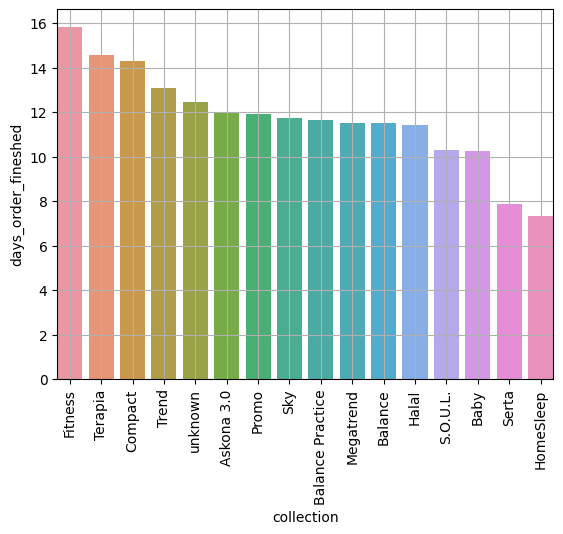

In [293]:
show_hist('collection', 'days_order_fineshed', 'mean')

Действительно, время доставки зависит от коллекции. Предположим, что на производстве несколько линий и на популярные коллекции производитель подключает дополнительные мощности.

Посмотрим на количество проданных матрасов по коллекциям.

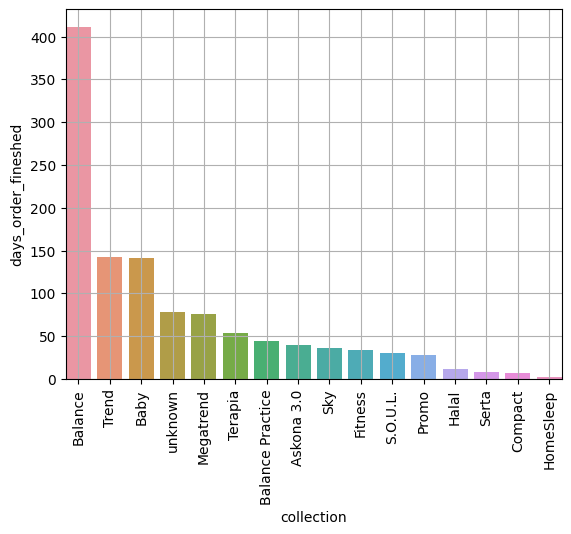

In [294]:
show_hist('collection', 'days_order_fineshed', 'count')

Самая продаваемая коллекция **Balnace**, а HomeSleep на последнем месте. 

Вероятнее всего скорость доставки зависит от наличия товара на складе, посмотри насколько разница.

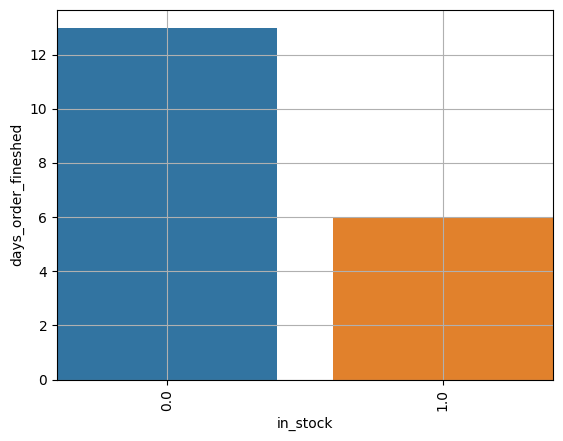

In [295]:
show_hist('in_stock', 'days_order_fineshed', 'median')

Если товар в налчии то, доставка более чем в два раза быстрее.

Матрасы бывают стандартного и не стандартного размера, для нестандартного размера другие этапы оформления заказа, по этому чаще всего они задерживаются. Посмотрим на графиках так ли это.

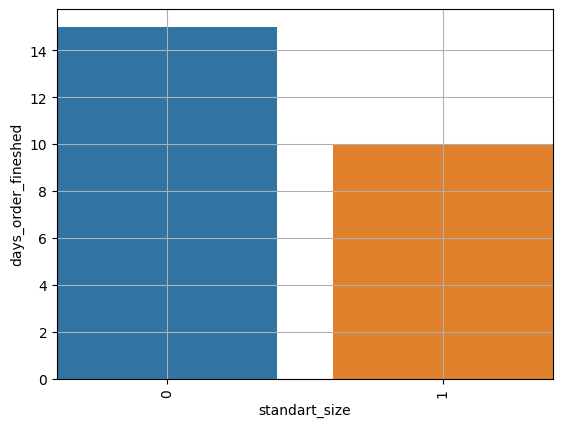

In [296]:
show_hist('standart_size', 'days_order_fineshed', 'median')

Интересно, а продается больше стандартов или не стандартов?

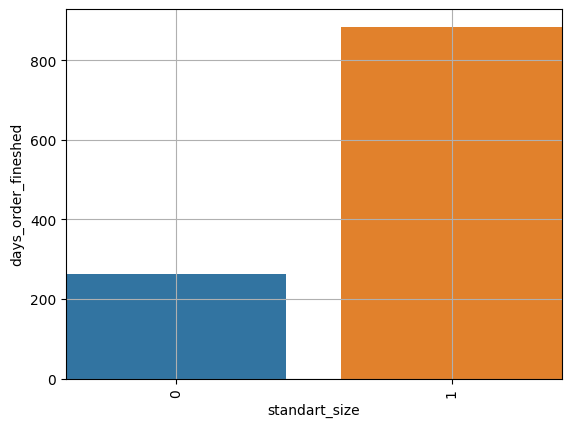

In [297]:
show_hist('standart_size', 'days_order_fineshed', 'count')

Как меняются сроки доставки от сезона?

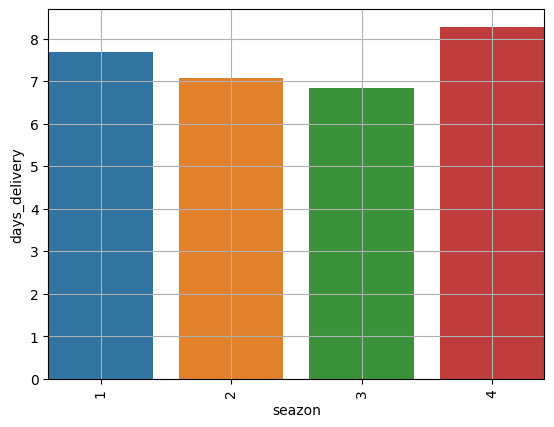

In [298]:
show_hist('seazon', 'days_delivery', 'mean')

Сроки доставки Весной - Летом наименьшие, в отличии от Осень - Зима. Как погода затрудняет доставку, так и праздники!

А нагрузка на производство?

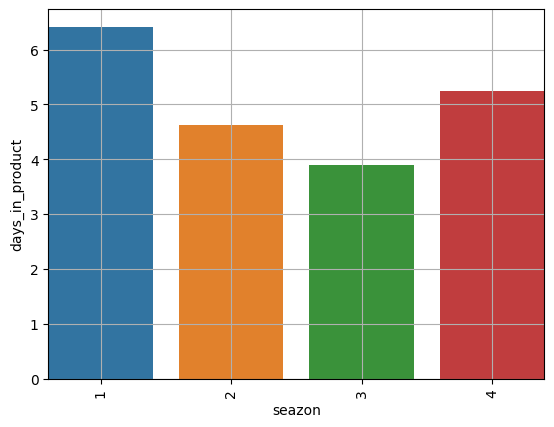

In [299]:
show_hist('seazon', 'days_in_product', 'mean')

Осенью-зимой нагрузка возрастает, а весна - лето падает. Матрасы - сезонный товар, а зимоей еще и длинные выходные.

### Вывод

Были првоерены основные утверждения заказчика, о том что сроки доставки зависят от:
* наличия на складе
* от стандартного / не стандартного рзамера
* от коллекции

Эти утверждения оказались верными.

Хочется отдельно отметить что сроки доставки зависят от сезонности как погодной так и сезонности товара.

## 3. Обучение модели

Данных для обучение и тестирования не много, по этому выбрали три модели:

* Линейная регрессия
* Случайный лес
* CatBoost

In [300]:
# разобьем на трейн и тест выборку
drop_columns = ['id',
                'contact_name',
                'product_name',
                'send_to_product',
                'askona_id',
                'askona_date_order',
                'askona_send_to_product',
                'askona_delivery',
                'days_order_fineshed',
                'days_in_product',
                'days_delivery',
                #'seazon',
                'create_datetime',
                #'diff_time_sm_askona',
                ] 
X_train, X_test, y_train, y_test = train_test_split(data.drop(drop_columns, axis=1), 
                                                    data['days_order_fineshed'],
                                                    shuffle=True,
                                                    test_size=0.2,
                                                    random_state=RANDOM_STATE)

In [301]:
metrics = pd.DataFrame()

In [302]:
# стандартизируем данные
standard = StandardScaler()
columns = ['distance', 
           'duration', 
           'in_stock', 
           'standart_size', 
           'client_lat', 
           'client_lng', 
           'month', 
           'day', 
           'seazon',
           'dayofweek', 
           'avg_time_in_product', 
           'avg_time_in_delivery', 
           'avg_diff_time_sm_askona']

standard.fit(X_train[columns])

X_train[columns] = standard.transform(X_train[columns])
X_test[columns] = standard.transform(X_test[columns])

In [303]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 916 entries, 1216 to 1787
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   collection               916 non-null    object 
 1   region_id                916 non-null    object 
 2   distance                 916 non-null    float64
 3   duration                 916 non-null    float64
 4   client_lat               916 non-null    float64
 5   client_lng               916 non-null    float64
 6   standart_size            916 non-null    float64
 7   in_stock                 916 non-null    float64
 8   month                    916 non-null    float64
 9   day                      916 non-null    float64
 10  dayofweek                916 non-null    float64
 11  seazon                   916 non-null    float64
 12  avg_time_in_product      916 non-null    float64
 13  avg_time_in_delivery     916 non-null    float64
 14  diff_time_sm_askona   

In [304]:
# сохраним обученый скаллер
pickle.dump(standard, open('scaler_v2.pkl','wb'))
data.to_csv('data_v2.csv')

In [305]:
# Порядковое кодирование для категориальных переменных
ordinal = OrdinalEncoder()
X_ordinal = X_train.copy()
columns = ['collection']

X_ordinal[columns] = ordinal.fit_transform(X_ordinal[columns])

standard = StandardScaler()
columns = ['collection', 'region_id']
standard.fit(X_ordinal[columns])
X_ordinal[columns] = standard.transform(X_ordinal[columns])

#

In [306]:
# функция для обучения моделей
def models(model, params, X_train, y_train, metrics, model_name): 

    clf = RandomizedSearchCV(model, 
                             params, 
                             n_jobs=4, 
                             scoring='neg_root_mean_squared_error', 
                             random_state=RANDOM_STATE,
                             cv=4)
    search = clf.fit(X_train, y_train) 

    if len(metrics) > 0:
        metrics = metrics.append(pd.DataFrame({
            'RMSE': -1 * search.best_score_
        }, index=[model_name])) 
        return search, metrics
    return search

In [307]:
model = LinearRegression()

metrics = metrics.append(pd.DataFrame({
        'RMSE': -1 * cross_val_score(model, X_ordinal, y_train, scoring='neg_mean_squared_error', cv=4).mean()
    }, index=['Base LinearRegression']))  

C:\Users\User\AppData\Local\Temp\ipykernel_15172\1036320325.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(pd.DataFrame({


In [308]:
model = RandomForestRegressor(random_state=RANDOM_STATE)
search, metrics = models(model, {}, X_ordinal, y_train, metrics, 'Base RandomForestRegressor')

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


C:\Users\User\AppData\Local\Temp\ipykernel_15172\4026813518.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(pd.DataFrame({


In [309]:
model = CatBoostRegressor(loss_function='RMSE', 
                          cat_features=['region_id', 'collection'],
                          silent=True,
                          random_state=RANDOM_STATE,
                          )
search, metrics = models(model, {}, X_train, y_train, metrics, 'Base CatBoostRegressor')

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\User\AppData\Local\Temp\ipykernel_15172\4026813518.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(pd.DataFrame({


In [310]:
metrics

,RMSE
Base LinearRegression,25.785167
Base RandomForestRegressor,5.052521
Base CatBoostRegressor,4.944879


Лучшая базовая модель Catboost. Проверим на тестовой выборке и подберем параметры.

## 3. Проверка модели

Подберем параметры для лучшей модели и проверим ее на тестовой выборке.

In [311]:
params = {'learning_rate': np.arange(0.01, 0.3, 0.005),
          'depth': [4, 6, 10],
          'reg_lambda': [1, 3, 5, 6, 7]} 
 
#params = {'reg_lambda': [1], 'learning_rate': [0.034999999999999996], 'depth': [10]}

model = CatBoostRegressor(grow_policy='Depthwise', 
                          score_function='L2', 
                          loss_function='RMSE', 
                          cat_features=['region_id', 'collection'], 
                          silent=True, 
                          random_state=RANDOM_STATE)

cb_model = models(model, params, X_train, y_train, [], 'CatBoost')

In [312]:

#model.save_model('delivery_model_v2')
X_test['real'] = y_test
X_test['pred'] = cb_model.predict(X_test)
print("RMSE:", mean_squared_error(y_test, X_test['pred']) ** 0.5)

RMSE: 3.6392743770195333


Посмотрим на важность признаков.

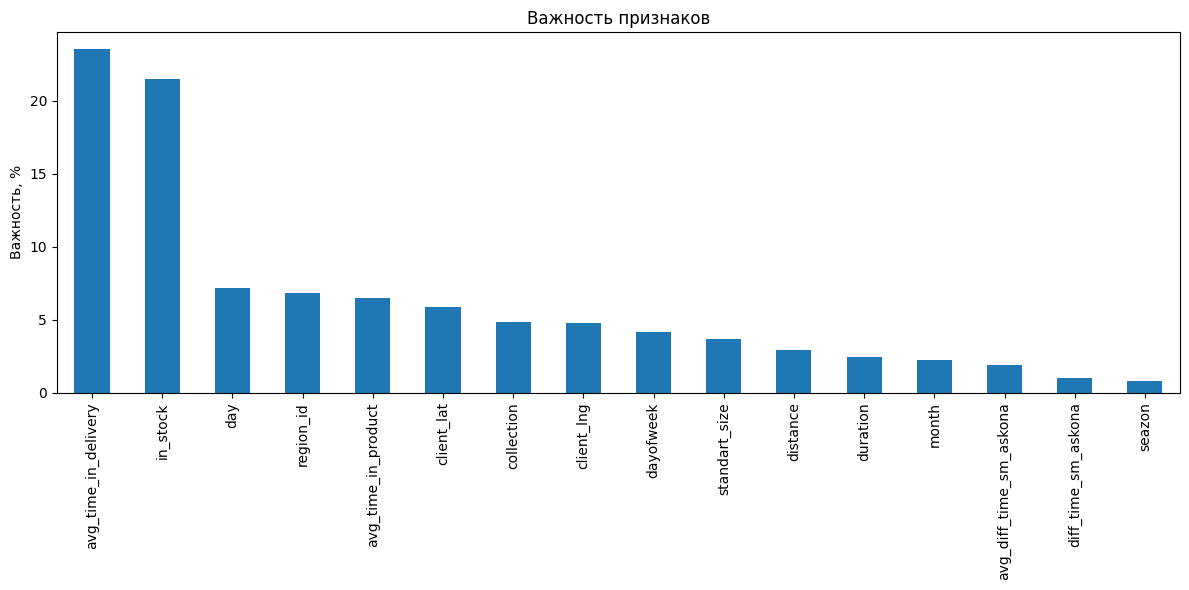

In [313]:
feaure_importance = pd.Series(cb_model.best_estimator_.feature_importances_, X_train.columns)
feaure_importance = feaure_importance.sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(12, 6))
feaure_importance.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

## 4. Общий вывод

В данном проекте были проблемы с заполнением и нехваткой необходимых признаков. Неправильно заполненные признаки были исправлены, дополнительные данные были сгенерированы при помощи двух сервисов:
* Dadata
* project-osrm.org

В результате анализа выявили, что необходимо пересмотреть целевой признак, т.к он включает в себя время обработки заказа менеджером, а его нужно исключить. Выяснилось, что есть история заказов и дата доставки в файлах которые производитель присылает на почту ежедневно. Из этих файлов так же получилось извлечь доп. признаки.


Так же подтвердилось что, сроки доставки зависят от:

* Коллекции
* Стандартного / не стандартного размера товара
* Загруженности производства, а загруженность зависит от сезонности товара.
* Доставка так же зависит от сезонности.

Обучили три базовые модели:

In [314]:
metrics

,RMSE
Base LinearRegression,25.785167
Base RandomForestRegressor,5.052521
Base CatBoostRegressor,4.944879


Из приведенных выше моделей выбрали лучшую **CatBoost**, подобали гиперпараметры. Результат на тестовой выборке следующий:

In [315]:
print("RMSE:", mean_squared_error(y_test, X_test['pred']) ** 0.5)

RMSE: 3.6392743770195333


Считаем данную ошибку допустипой для развертывания. Код развертывания можете посмотреть в файле **index_step_2.ipynb**